# Solutions IV: Validation and Selection

In [1]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import accuracy_score

## Load Data

In [2]:
# Read in the banking data set.
df = pd.read_csv("../../0_data/banking/bank-additional-full.csv", sep=";")
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Split features and labels.
X = df.drop(columns=["duration", "pdays", "y"])
y = df["y"]

## Create Models

In [4]:
# Get column names per data type.
categorical = X.select_dtypes("object").columns
numerical = X.select_dtypes("number").columns

In [5]:
# Set up the data preparation.
transformer = ColumnTransformer(
    transformers=[
        ("encode_categorical", OneHotEncoder(handle_unknown="ignore"), categorical),
    ],
    remainder="passthrough",
)

In [6]:
# Create the DummyClassifier.
dummy_model = DummyClassifier(strategy="stratified")

In [7]:
# Create pipeline for the RandomForestClassifier.
forest_model = Pipeline(
    steps=[
        ("preparation", transformer),
        ("model", RandomForestClassifier(n_jobs=-1)),
    ]
)

## Train versus Test Performance

In [8]:
# Split X and y into train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [9]:
# Check sizes
print("Total records: ", X.shape[0])
print("Train records: ", X_train.shape[0])
print("Test  records: ", X_test.shape[0])

Total records:  41188
Train records:  28831
Test  records:  12357


In [24]:
# Get performance of DummyClassifier and RandomForestClassifier.
# Report performance on both train and test sets.
models = {"Dummy": dummy_model, "RandomForest": forest_model}

print("-" * 40)
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    
    # Compute accuracy
    train_acc = accuracy_score(y_train, predict_train)
    test_acc = accuracy_score(y_test, predict_test)
    
    # Print report
    print(f"Model:              {model_name:>20s}")
    print(f"Accuracy train:     {train_acc:20.3f}")
    print(f"Accuracy test:      {test_acc:20.3f}")
    print("-" * 40)

----------------------------------------
Model:                             Dummy
Accuracy train:                    0.881
Accuracy test:                     0.663
----------------------------------------
Model:                      RandomForest
Accuracy train:                    0.994
Accuracy test:                     0.693
----------------------------------------


In [11]:
# Note: The RandomForestClassifier seems to overfit quite a bit.

In [25]:
# Does DummyClassifier outperform always predicting no?
# It does not, because it draws at random from the labels yes / no.
print("Accuracy Always No")
print(f"Accuracy train: {(y_train == 'no').sum() / y_train.shape[0]:.3f}")
print(f"Accuracy test:  {(y_test == 'no').sum()  / y_test.shape[0]:.3f}")

Accuracy Always No
Accuracy train: 0.936
Accuracy test:  0.692


## Cross Validation

In [26]:
# Create KFold object and specify number of splits.
kfold = KFold(n_splits=5)

In [27]:
# Perform cross-validation with 5 splits.
kfold = KFold(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), start=1):
    
    # Create data sets for the fold.
    # Note: Use .iloc[] because we get indices!
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
        
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
        
    # Train the model, get predictions and accuracy.
    forest_model.fit(X_train, y_train)
    predictions = forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)    
    
    # Print details.
    print(f"----------- [Fold {fold}] ----------")
    print(f"Test cases:       {test_idx[0]:5d} - {test_idx[-1]:5d}")
    print(f"Accuracy:         {accuracy:13.3f}")

----------- [Fold 1] ----------
Test cases:           0 -  8237
Accuracy:                 0.969
----------- [Fold 2] ----------
Test cases:        8238 - 16475
Accuracy:                 0.944
----------- [Fold 3] ----------
Test cases:       16476 - 24713
Accuracy:                 0.941
----------- [Fold 4] ----------
Test cases:       24714 - 32950
Accuracy:                 0.888
----------- [Fold 5] ----------
Test cases:       32951 - 41187
Accuracy:                 0.693


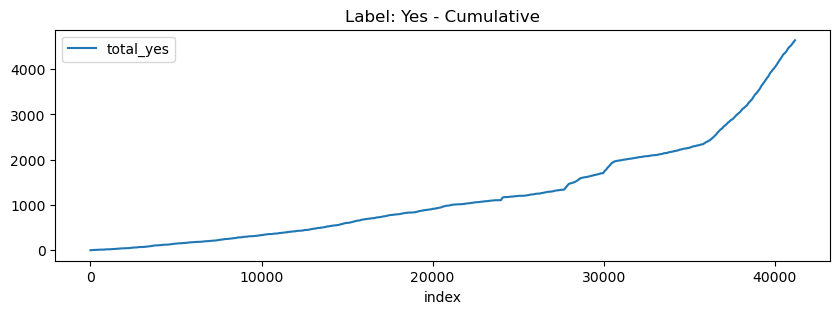

In [28]:
# Plot occurrence of the "yes" label throughout the dataset.
(
    pd.DataFrame({
        "index": df.index,
        "total_yes": (df["y"] == "yes").cumsum(),
    })
    .plot(
        x="index",
        y="total_yes",
        title="Label: Yes - Cumulative",
        figsize=(10, 3),
    )
)
None

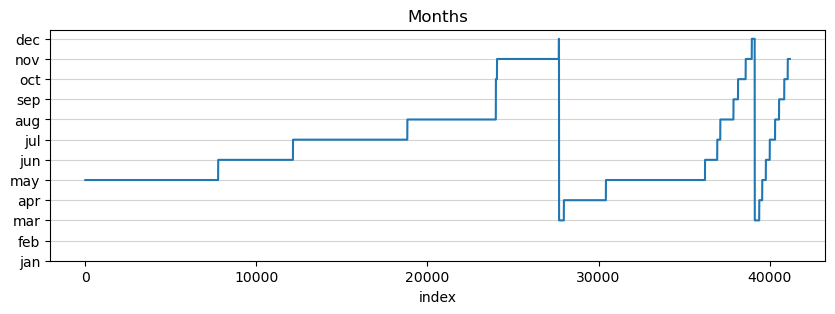

In [16]:
# Plot dispersion of the months throughout the dataset.
months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
ax = (
    pd.DataFrame({
        "index": df.index,
        "month_num": df["month"].map(lambda m: months.index(m) + 1)
    })
    .plot(
        x="index",
        y="month_num",
        title="Months",
        figsize=(10, 3),
        legend=False,
    )
)
ax.set_yticks([m + 1 for m in range(12)], months)
ax.grid(visible=True, color="lightgrey", axis="y")
None

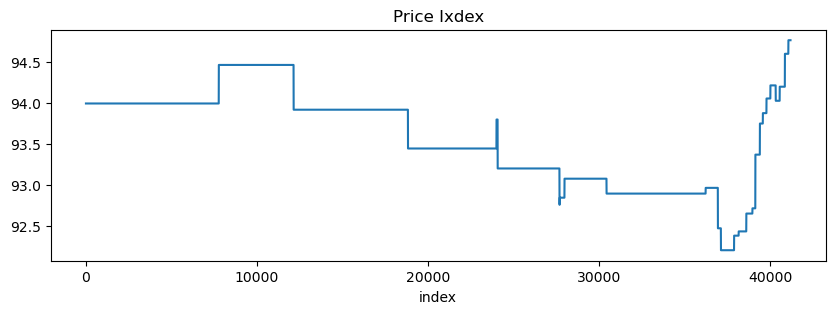

In [17]:
# Plot how price index changes throughout the dataset.
ax = (
    pd.DataFrame({
        "index": df.index,
        "price_index": df["cons.price.idx"]
    })
    .plot(
        x="index",
        y="price_index",
        title="Price Ixdex",
        figsize=(10, 3),
        legend=False,
    )
)
None